# CSN-Pytorch

## Imports

In [1]:
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import wandb
from csn import csn152
from torchvision import transforms
from video_dataset import VideoFrameDataset, ImglistToTensor

wandb.init(entity="cares", project="autoencoder-experiments", group="pytorch-csn")

wandb: Currently logged in as: sttaseen (cares). Use `wandb login --relogin` to force relogin


## Device Agnostic Code

In [2]:
try:
    device = 'mps' if torch.backends.mps.is_available() else 'cpu'
except:
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Data Setup

In [3]:
data_root = os.path.join(os.getcwd(), 'data/wlasl/rawframes') 
ann_file_train = os.path.join(os.getcwd(), 'data/wlasl/train_annotations.txt') 
ann_file_test = os.path.join(os.getcwd(), 'data/wlasl/test_annotations.txt')
batch_size = 20

# Setting up data augments
train_pipeline = transforms.Compose([
        ImglistToTensor(), # list of PIL images to (FRAMES x CHANNELS x HEIGHT x WIDTH) tensor
        transforms.Resize(256), # image batch, resize smaller edge to 256
        transforms.RandomResizedCrop((224, 224)), # image batch, center crop to square 224x224
        transforms.RandomHorizontalFlip(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

test_pipeline = transforms.Compose([
        ImglistToTensor(), # list of PIL images to (FRAMES x CHANNELS x HEIGHT x WIDTH) tensor
        transforms.Resize(256),  # image batch, resize smaller edge to 256
        transforms.CenterCrop((224, 224)),  # image batch, center crop to square 224x224
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

# Setting up datasets
train_dataset = VideoFrameDataset(
    root_path=data_root,
    annotationfile_path=ann_file_train,
    num_segments=5,
    frames_per_segment=1,
    imagefile_template='img_{:05d}.jpg',
    transform=train_pipeline,
    test_mode=False
)


test_dataset = VideoFrameDataset(
    root_path=data_root,
    annotationfile_path=ann_file_test,
    num_segments=5,
    frames_per_segment=1,
    imagefile_template='img_{:05d}.jpg',
    transform=test_pipeline,
    test_mode=True
)

# Setting up dataloaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                    batch_size=batch_size,
                                    shuffle=False,
                                    num_workers=4,
                                    pin_memory=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                    batch_size=2,
                                    shuffle=False,
                                    num_workers=4,
                                    pin_memory=False)

In [4]:
dataiter = iter(train_loader)
get = next(dataiter)
get[0].shape

torch.Size([20, 5, 3, 224, 224])

In [5]:
get = next(dataiter)
get[0].shape

torch.Size([20, 5, 3, 224, 224])

In [6]:
# Testing dataloader
dataiter = iter(train_loader)
get = next(dataiter)
get[0].size(0)

20

In [7]:
reshape = get[0].permute(0,2,1,3,4)
reshape.shape

torch.Size([20, 3, 5, 224, 224])

## Set up model, loss, optimiser and others

In [8]:
# Create a CSN model
csn = csn152(num_classes=400)

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

# Specify loss function
optimizer = torch.optim.SGD(csn.parameters(), lr=0.000125, momentum=0.9, weight_decay=0.0001)

# Specify learning rate scheduler
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[12,16])

# Setup wandb
wandb.watch(csn, log_freq=100)

[]

## Train model

In [9]:
epochs = 150
interval = 10 # For checkpoints and validation

losses = []
eval_accu = []
eval_losses=[]

csn.to(device)
csn.train()

for epoch in range(epochs):
    # Reset train loss
    train_loss = 0.0
    for video_batch, targets in train_loader:
        # Move data to device
        video_batch, targets = video_batch.to(device), targets.to(device)
        
        # batch_size, n_frames, channels, h, w -> previous doesn't work
        # batch_size, channels, n_frames, h, w -> current
        predictions = csn(video_batch.permute(0,2,1,3,4))
        
        # Calculate loss
        loss = loss_fn(predictions, targets)
        
        # Backpropagate
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        scheduler.step()
        
        # Calculate batch loss
        train_loss += loss.item()

    
    # Check for interval to validate and save checkpoints
    if interval!=0 and epoch%interval==0:
        running_loss=0
        correct=0
        total=0
        with torch.no_grad():
            for video_batch, targets in test_loader:
                video_batch, targets = video_batch.to(device), targets.to(device)

                predictions = csn(video_batch.permute(0,2,1,3,4))
                x = predictions
                
                loss = loss_fn(predictions, targets)
                running_loss += loss.item()

                _, predicted = predictions.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

        test_loss=running_loss/len(test_loader)
        accu=100.*correct/total

        eval_losses.append(test_loss)
        eval_accu.append(accu)
        print('Test Loss: %.3f | Accuracy: %.3f'%(test_loss,accu)) 

    train_loss = train_loss/len(train_loader)
    losses.append(train_loss)
    print(f'Epoch: {epoch+1} \tTraining Loss: {train_loss:.6f}')
    
    # Wandb Log
    wandb.log({"loss": loss,
              "val/top_1_acc": accu})

Test Loss: 6.144 | Accuracy: 1.163
Epoch: 1 	Training Loss: 6.203974
Epoch: 2 	Training Loss: 6.136650
Epoch: 3 	Training Loss: 6.114966
Epoch: 4 	Training Loss: 6.111706
Epoch: 5 	Training Loss: 6.095893
Epoch: 6 	Training Loss: 6.080412
Epoch: 7 	Training Loss: 6.066241
Epoch: 8 	Training Loss: 6.054830
Epoch: 9 	Training Loss: 6.036645
Epoch: 10 	Training Loss: 6.028039
Test Loss: 6.004 | Accuracy: 1.550
Epoch: 11 	Training Loss: 6.007580
Epoch: 12 	Training Loss: 5.994394
Epoch: 13 	Training Loss: 5.989599
Epoch: 14 	Training Loss: 5.966802
Epoch: 15 	Training Loss: 5.959431
Epoch: 16 	Training Loss: 5.940715
Epoch: 17 	Training Loss: 5.929746
Epoch: 18 	Training Loss: 5.921752
Epoch: 19 	Training Loss: 5.907103
Epoch: 20 	Training Loss: 5.897848
Test Loss: 5.879 | Accuracy: 1.550
Epoch: 21 	Training Loss: 5.883977
Epoch: 22 	Training Loss: 5.869026
Epoch: 23 	Training Loss: 5.861079
Epoch: 24 	Training Loss: 5.847597
Epoch: 25 	Training Loss: 5.837798
Epoch: 26 	Training Loss: 5.8

Text(0.5, 0, 'Epoch')

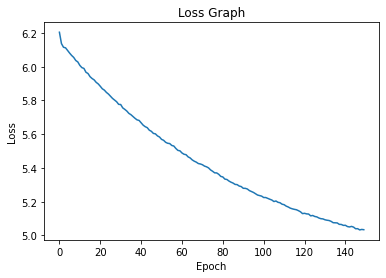

In [10]:
plt.plot(losses)
plt.title('Loss Graph')
plt.ylabel('Loss')
plt.xlabel('Epoch')